# 5. Quality assessment of solar irradiance data




Intro text about quality assessment.

Why do we do it. Common errors.

Flags

There exists two software pacakges with capabilities of quality assessment of solar irradiance data; QCrad developed by NREL and Meteorological Data Management System (MDMS). While these softwares provide userfriendly tools to local station managers,


<br>

### 5.1 Load data
In order to demonstrate the quality assessment methods which will be introduced in this notebook, some sample data is needed. In the following code block, a two year dataset of GHI, DHI, and DNI from the [Technical University of Denmark](http://climatestationdata.byg.dtu.dk/GetData) is read into a Pandas DataFrame. It is importan to note, that in order to calculate solar angles and sunrise/sunset times, the index must be timezone aware.

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pvlib

df = pd.read_csv('C:/Users/arajen/Downloads/solar_irradiance_dtu_2018_2020.csv', index_col=[0], parse_dates=[0])
df.index = df.index.tz_localize('UTC') # Make index timezone aware
df.head()

,GHI,DHI,DNI,zenith,azimuth
Time(utc),,,,,
2018-01-01 00:00:00+00:00,0.01471,-0.022330,0.004737,146.110116,19.542241
2018-01-01 00:01:00+00:00,0.05884,-0.033500,0.009474,146.062597,19.945594
2018-01-01 00:02:00+00:00,0.04597,0.000000,0.024865,146.014149,20.348092
2018-01-01 00:03:00+00:00,0.06252,-0.013400,0.020133,145.964777,20.749721
2018-01-01 00:04:00+00:00,0.08642,0.007817,0.033159,145.914485,21.150468


<br>

## 5.2 Visual inspection
The first check of the data consists of a visualization of the time series. For this purpose, the different measurements have been plotted as a function of time next to a histogram. Generally, this first qualitative analysis allows detecting major issues in the measurement. For our test sites, only slightly high DHI values can be observed for some stations. Nevertheless, it is not possible to judge their plausibility at this stage of the data analysis.

Wall time: 15.5 s


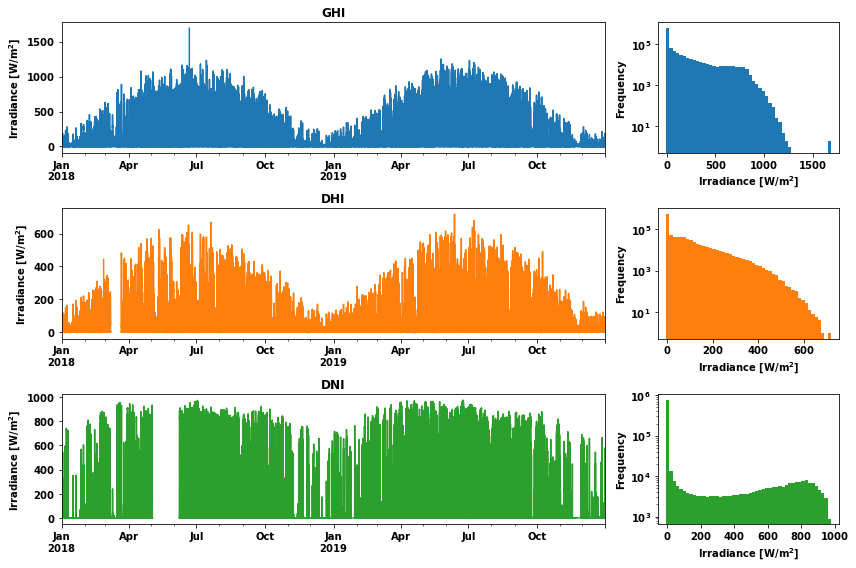

In [115]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), gridspec_kw={'width_ratios':[3,1]})
for i, c in enumerate(['GHI','DHI','DNI']):
    df[c].plot(ax=axes[i,0], c='C{}'.format(i), title=c)
    df[c].plot.hist(ax=axes[i,1], logy=True, bins=50, facecolor='C{}'.format(i))
    axes[i,0].set_xlabel('')
    axes[i,0].set_ylabel('Irradiance [W/m$^2$]')
    axes[i,1].set_xlabel('Irradiance [W/m$^2$]')
fig.tight_layout()

<br>

## 5.3 Two-dimensional visual inspection
In the general visualization above it is possible to detect large gaps, extreme values, and seasonal variations. However, the variation in data during a day is smothered and pratically indistinguisable due to the large amount of data.

Therefore, a two-dimensional visualization method is presented in this section, where the x-axis coresponds to the day, the y-axis corresponds to the time of day and the pixel color corresponds the measurement value. The strength of this two-dimensional method is that each data point is visible, allowing for both intra-day and seasonal trends to be  visible. This is particularly useful in identifying errors over time, such as time shifts, missing data and sometimes shading.

To add structure to the 2D plots, we will plot the sunrise and sunset times, which are calculated as:

In [46]:
days = pd.date_range(df.index[0], df.index[-1]) # List of days for which to calculate sunrise/sunset
sunrise_sunset = pvlib.solarposition.sun_rise_set_transit_spa(days, latitude=55.791, longitude=12.525)
sunrise_sunset['sunrise'] = sunrise_sunset['sunrise'].dt.hour + sunrise_sunset['sunrise'].dt.minute/60
sunrise_sunset['sunset'] = sunrise_sunset['sunset'].dt.hour + sunrise_sunset['sunset'].dt.minute/60

Next, the 2D DataFrame is created and plotted:

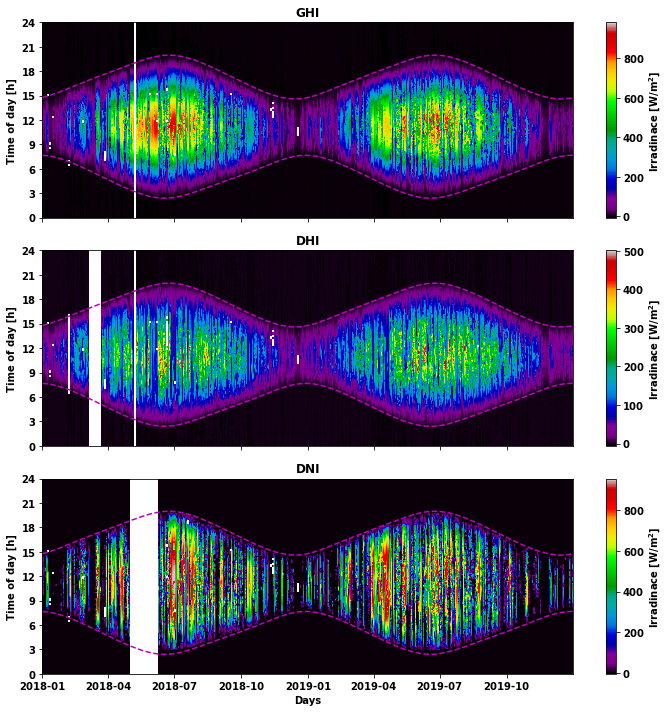

In [129]:
# Creation of the 2D dataframe, with time-of-day as rows and days as columns
df_2d = df.set_index([df.index.date, df.index.hour+df.index.minute/60]).unstack(level=0)

# Calculate the extents of the 2D plot, in the format [x_start, x_end, y_start, y_end]
xlims = mdates.date2num([df.index[0].date(), df.index[-1].date()])
extent = [xlims[0], xlims[1], 0, 24]

# Generate subplots and plot 2D DataFrame and sunrise/sunset line
fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
for i, c in enumerate(['GHI','DHI','DNI']):
    im = axes[i].imshow(df_2d[c], aspect='auto', origin='lower', cmap='nipy_spectral',
                        extent=extent, vmax=df[c].quantile(0.999))
    axes[i].set_title(c)
    axes[i].xaxis_date()
    axes[i].set_yticks(np.arange(0,25,3))
    axes[i].set_ylabel('Time of day [h]')
    axes[i].plot(mdates.date2num(sunrise_sunset.index), sunrise_sunset[['sunrise', 'sunset']], 'm--')
    cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', label='Irradinace [W/m$^2$]')
axes[-1].set_xlabel('Days')
fig.tight_layout()

<br>

## 5.4 Intra-day methods

The first step that should be done is to check for missing values. This is best done with a visualization, as this makes it possible to detect patterns of the missing data.

In [ ]:
# %% Analysis of the shadow surrounding the station

vSEA = QC_df.loc[QC_df.GAMMA_S0>1/50,'GAMMA_S0']
vSAA = QC_df.loc[QC_df.GAMMA_S0>1/50,'ALPHA_S']
vBNI = QC_df.loc[QC_df.GAMMA_S0>1/50,'BNI']


idx_sort = np.argsort(vBNI.values)

# call the wps to obtain the horiyon line calculated with SRTM elevation data
location = [Latitude, Longitude, Elevation]
HZ = wps.wps_Horizon_SRTM(location)

fig = plt.figure(figsize=(15,8))
plt.scatter(vSAA[idx_sort]*180/np.pi, vSEA[idx_sort]*180/np.pi, s=5, c=vBNI[idx_sort], cmap=newcmp, marker='s',alpha=.5)
plt.title(r'Maximum BNI in (Azimuth, Elevation) $(W.m^{-2})$')
plt.xlabel('Elevation [°]')
plt.ylabel('Azimuth [°]')
cb=plt.colorbar()
plt.plot(HZ.AZIMUT,HZ.ELEVATION,'k',linewidth=2)
cb.set_label('BNI $(W.m^{-2})$', rotation=270)
plt.xlim((45,315))

<br>

## 5.5 Long-term methods

### References

Keep it simple!

Less code is more useful.

Often a simpler representation is better than a slight better more complex way.

<AxesSubplot:ylabel='Frequency'>

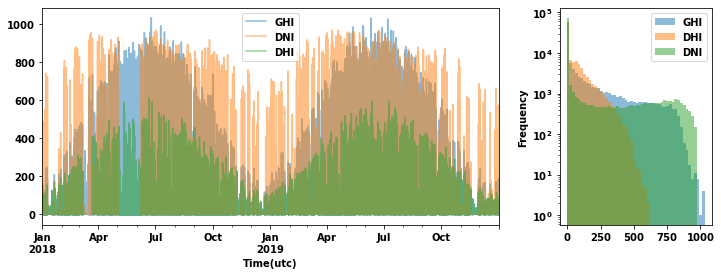

In [103]:
# Alternative visualization plot
fig, axes = plt.subplots(ncols=2, figsize=(12,4), gridspec_kw={'width_ratios':[3,1]})
df_10min[['GHI','DNI','DHI']].plot(ax=axes[0], alpha=0.5)#, alpha=[1,0.8,0.5])
df_10min[['GHI','DHI','DNI']].plot.hist(ax=axes[1], logy=True, bins=50, alpha=0.5)